In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
import keras.backend as K

import tensorflow as tf

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio

from scipy.stats import pearsonr

import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

from aparent.data.aparent_data_plasmid_legacy import load_data

from analyze_aparent_conv_layers_helpers import *


Using TensorFlow backend.


In [ ]:
#Load random MPRA data

file_path = '../data/random_mpra_legacy/combined_library/processed_data_lifted/'
plasmid_gens = load_data(batch_size=32, valid_set_size=1000, test_set_size=20000, kept_libraries=[22], canonical_pas=True, file_path=file_path)


In [3]:
#Re-shuffle test set index

plasmid_index = np.arange(len(plasmid_gens['all'].sources['df']), dtype=np.int)
np.random.shuffle(plasmid_index)

plasmid_gens['test'].data_ids = plasmid_index[:20000]


In [5]:
#Load legacy APARENT model (lifted from theano)

model_name = 'aparent_theano_legacy_30_31_34'#_pasaligned

save_dir = os.path.join(os.getcwd(), '../saved_models/legacy_models')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)

In [ ]:
#Create a new model that outputs the conv layer activation maps together with the isoform proportion
conv_layer_cut_model = Model(
    inputs = aparent_model.inputs,
    outputs = [
        aparent_model.get_layer('cut_conv_layer_1').output,
        aparent_model.get_layer('cut_out_layer_1').output
    ]
)

In [ ]:
#Predict from test data generator
cut_conv_1_out, cut_pred = conv_layer_cut_model.predict_generator(plasmid_gens['test'], workers=4, use_multiprocessing=True)

cut_conv_1_out = np.reshape(cut_conv_1_out, (cut_conv_1_out.shape[0], cut_conv_1_out.shape[1], cut_conv_1_out.shape[2]))

#Retrieve one-hot input sequences
onehot_seqs = np.concatenate([plasmid_gens['test'][i][0][0][:, 0, :, :] for i in range(len(plasmid_gens['test']))], axis=0)

cut_logodds = np.log(cut_pred / (1. - cut_pred))


In [ ]:
#Mask for simple library (Alien1)
mask_seq = ('X' * 4) + ('N' * (45 + 6 + 45 + 6 + 45)) + ('X' * 27) #178

for j in range(len(mask_seq)) :
    if mask_seq[j] == 'X' :
        cut_conv_1_out[:, :, j] = 0


In [ ]:
#Slice out only the interesting sequence region (DSE)

cut_pred = cut_pred[:, 55: 100]
cut_logodds = cut_logodds[:, 55: 100]
cut_conv_1_out = cut_conv_1_out[:, :, 55: 100 - 8]
onehot_seqs = onehot_seqs[:, 55: 100 - 8 + 8, :]


In [ ]:
#Layer 1: Compute Max Activation Correlation maps and PWMs
filter_width = 8
n_samples = 1500

pwms = np.zeros((cut_conv_1_out.shape[1], filter_width, 4))
pwms_top = np.zeros((cut_conv_1_out.shape[1], filter_width, 4))

for k in range(cut_conv_1_out.shape[1]) :
    
    for i in range(cut_conv_1_out.shape[0]) :
        max_j = np.argmax(cut_conv_1_out[i, k, :])
        if cut_conv_1_out[i, k, max_j] > 0 :
            pwms[k, :, :] += onehot_seqs[i, max_j: max_j+filter_width, :]
    
    sort_index = np.argsort(np.max(cut_conv_1_out[:, k, :], axis=-1))[::-1]
    for i in range(n_samples) :
        max_j = np.argmax(cut_conv_1_out[sort_index[i], k, :])
        if cut_conv_1_out[sort_index[i], k, max_j] > 0 :
            pwms_top[k, :, :] += onehot_seqs[sort_index[i], max_j: max_j+filter_width, :]
    
    
    pwms[k, :, :] /= np.expand_dims(np.sum(pwms[k, :, :], axis=-1), axis=-1)
    pwms_top[k, :, :] /= np.expand_dims(np.sum(pwms_top[k, :, :], axis=-1), axis=-1)

r_vals = np.zeros((cut_conv_1_out.shape[1], cut_conv_1_out.shape[2], cut_pred.shape[1]))

for k in range(cut_conv_1_out.shape[1]) :
    for j in range(cut_conv_1_out.shape[2]) :
        for v in range(cut_pred.shape[1]) :
            if np.any(cut_conv_1_out[:, k, j] > 0.) :
                r_val, _ = pearsonr(cut_conv_1_out[:, k, j], cut_logodds[:, v])
                #r_val, _ = pearsonr(cut_conv_1_out[:, k, j], cut_pred[:, v])
                r_vals[k, j, v] = r_val if not np.isnan(r_val) else 0


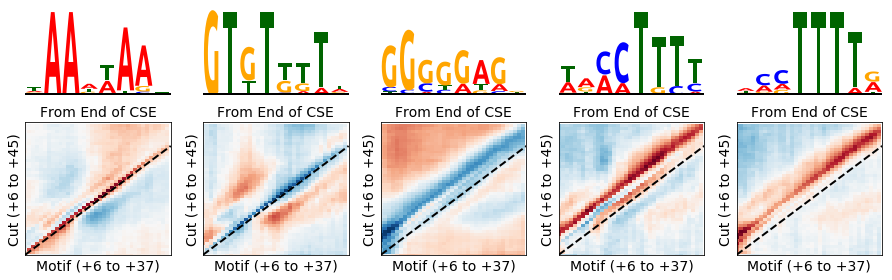

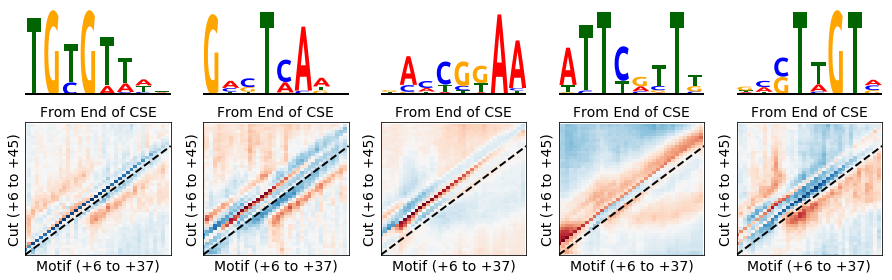

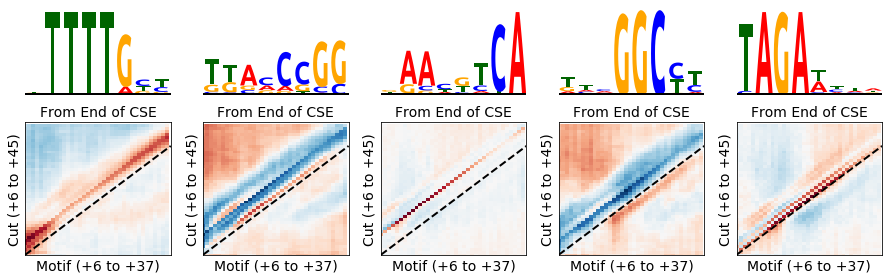

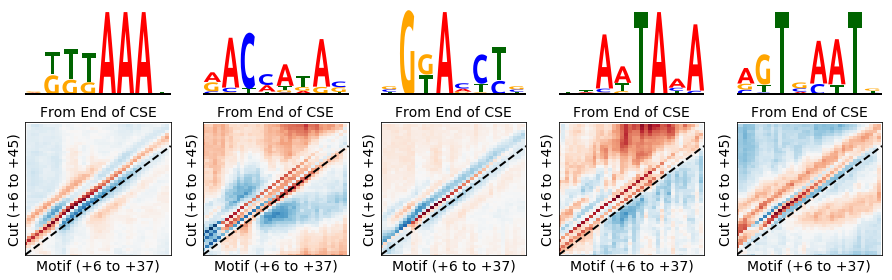

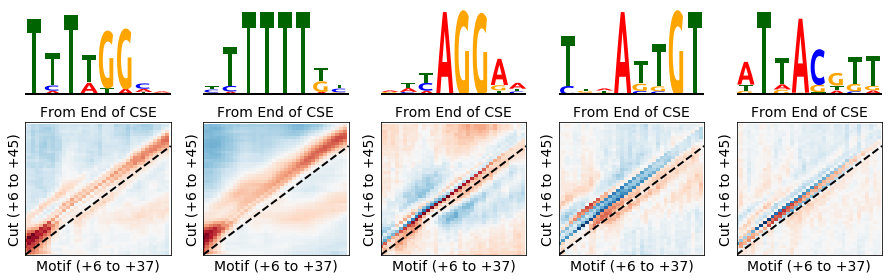

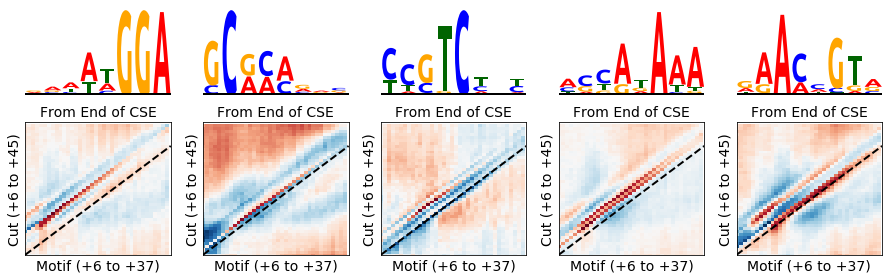

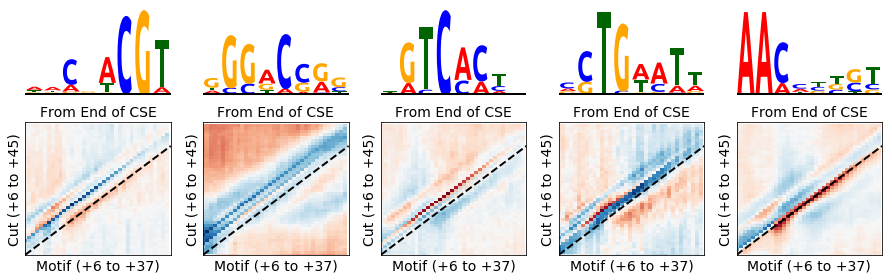

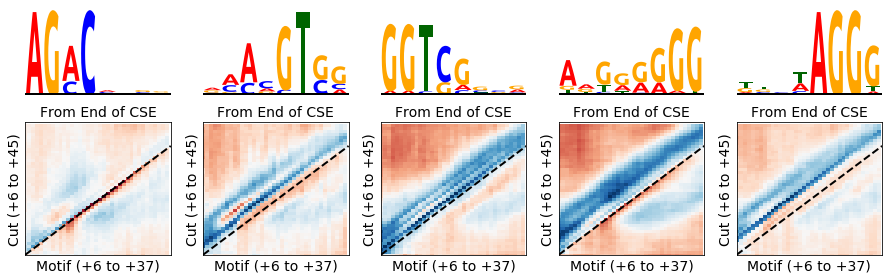

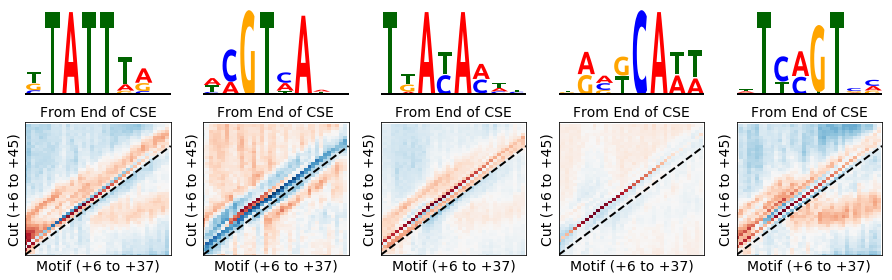

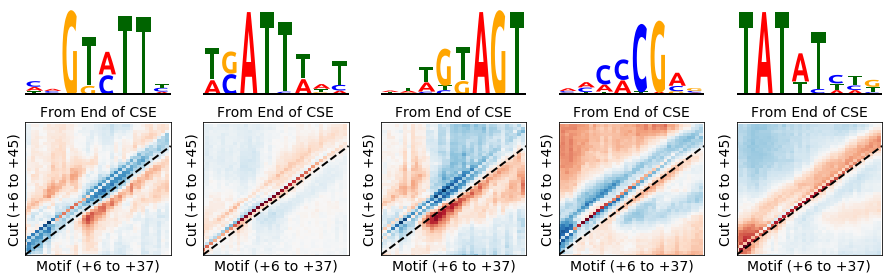

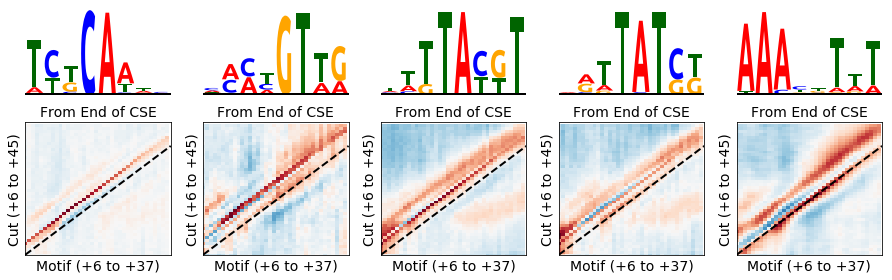

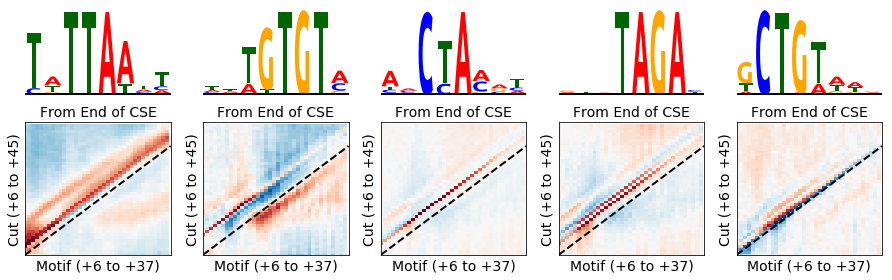

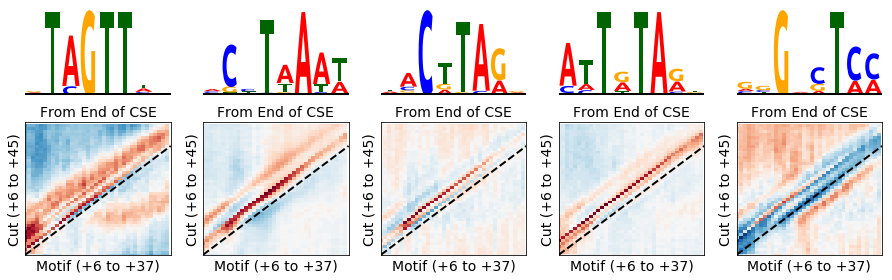

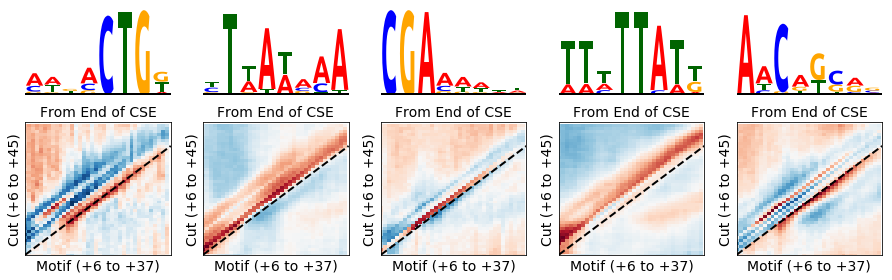

In [21]:
#Plot Max Activation PWMs and Correlation maps

n_filters_per_row = 5

n_rows = int(pwms.shape[0] / n_filters_per_row)
k = 0
for row_i in range(n_rows) :
    
    f, ax = plt.subplots(2, n_filters_per_row, figsize=(2.5 * n_filters_per_row, 4), gridspec_kw = {'height_ratios':[2, 3]})

    for kk in range(n_filters_per_row) :
        plot_pwm_cut_logo(pwms_top, r_vals, k, ax[0, kk], ax[1, kk])
        k += 1

    plt.sca(plt.gca())
    plt.tight_layout()

    plt.show()

